# Applying the U-Net to real seismic data (detections the hard way)

**Author:** Amanda M. Thomas  
**Goal:** In this notebook we will once again build the U-Net but this time instead of training we simply load in the model weights we saved after training.  We then apply the trained model to data from NCEDC stations that recorded the 2022 Ferndale earthquake.


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

## 1. Build the U-net

In [35]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

# 2. Load weights into the model

This cell loads the saved weights into the model.

In [36]:
model = UNet1D()
model.load_state_dict(torch.load("../Loic/UNet/model_weights_eq_only_v2.pt",weights_only=True, map_location=torch.device('cpu')))
model.eval() 

UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU

# 3. Load and preprocess MiniSEED waveform data

The most important thing here is to make sure that the input data is similar to the training set.  This includes insuring that the sample rates are the same and the same normalizations applied to the preprocessing steps are applied to the actual data.  This includes sample rates, normalizations, and component order.



In [42]:
# Load and preprocess MiniSEED waveform data
import numpy as np
from obspy import read, Stream, Trace

# the PNW dataset is in ENZ order, if only Z is present, we need to create dummy E and N traces
from obspy import Stream, Trace
import numpy as np

def ensure_ENZ_order(st):
    """
    Ensure a stream has channels in E, N, Z order.
    Handles both E/N/Z and 1/2/Z naming conventions.
    If only Z is present, creates dummy E and N traces filled with zeros.
    """
    # Normalize component keys (map 1 -> E, 2 -> N, Z stays Z)
    comp_map = {}
    for tr in st:
        suffix = tr.stats.channel[-1].upper()
        if suffix == "1":
            comp_map["E"] = tr
        elif suffix == "2":
            comp_map["N"] = tr
        else:
            comp_map[suffix] = tr

    print("Detected components:", comp_map.keys())

    # If only Z is present, create dummy E and N
    if set(comp_map.keys()) == {"Z"}:
        z_trace = comp_map["Z"]
        npts = z_trace.stats.npts
        sampling_rate = z_trace.stats.sampling_rate
        starttime = z_trace.stats.starttime

        # Create dummy E and N traces
        e_trace = Trace(data=np.zeros(npts, dtype=np.float32), header=z_trace.stats.copy())
        n_trace = Trace(data=np.zeros(npts, dtype=np.float32), header=z_trace.stats.copy())

        e_trace.stats.channel = z_trace.stats.channel[:-1] + "E"
        n_trace.stats.channel = z_trace.stats.channel[:-1] + "N"

        return Stream(traces=[e_trace, n_trace, z_trace])

    # Reorder to E, N, Z (if available)
    ordered = []
    for comp in ["E", "N", "Z"]:
        if comp in comp_map:
            ordered.append(comp_map[comp])

    return Stream(traces=ordered)



# Load the data
st = read('../data/B047.PB.EH*')
# Merge streams
st.merge(fill_value='interpolate')
# Ensure ENZ order
st = ensure_ENZ_order(st)
# Demean
st.detrend('demean')
# Resample to 100 Hz
for tr in st:
    if tr.stats.sampling_rate != 100:
        print(f"Resampling {tr.id} from {tr.stats.sampling_rate} Hz to {target_rate} Hz")
        tr.resample(target_rate)

# Your input data
data = np.stack([tr.data for tr in st], axis=0)  # shape: (channels, time)
chunk_size = 3001
num_channels, total_length = data.shape

# Calculate how much padding is needed
remainder = total_length % chunk_size
if remainder > 0:
    pad_width = chunk_size - remainder
    # Pad with zeros at the end along the time axis
    data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')

# Reshape to (num_chunks, 3, 3001)
num_chunks = data.shape[1] // chunk_size
chunks = data.reshape(num_channels, num_chunks, chunk_size).transpose(1, 0, 2)  # shape: (num_chunks, 3, 3001)

# Demean each chunk along the time axis
means = np.mean(chunks, axis=2, keepdims=True)  # shape: (num_chunks, 3, 1)
demeaned_chunks = chunks - means

# Normalize by the peak absolute value 
max_vals = np.max(np.abs(demeaned_chunks), axis=2, keepdims=True)  # shape: (num_chunks, 3, 1)
normalized_chunks = np.divide(
    demeaned_chunks,
    max_vals,
    out=np.zeros_like(demeaned_chunks),
    where=max_vals != 0
).astype(np.float32)

# Convert to torch tensor
input_tensor = torch.tensor(normalized_chunks, dtype=torch.float32, device=torch.device('cpu'))  # shape: (batch_size, 3, 3001)

Detected components: dict_keys(['E', 'N', 'Z'])


In [38]:
# Run inference
with torch.no_grad():
    pred = model(input_tensor).squeeze(0).cpu().numpy()  # shape: (2, T)

In [39]:
# Step 1: Reshape to (2, total_length_with_padding)
input_unwrapped = input_tensor.permute(1, 0, 2).reshape(3, -1)[:, :8640000]   # Shape: (3, num_chunks * 3001)
pred_unwrapped = pred.transpose(1, 0, 2).reshape(3, -1)[:, :8640000]   # shape: (2, num_chunks * 3001)

# 4. Write pick file

In [46]:
# Output file
output_file = 'detections_%s.%s.%s.%s.csv'%(tr.stats.network,tr.stats.station,tr.stats.starttime.year,tr.stats.starttime.julday)

import csv
from obspy import UTCDateTime
from scipy.signal import find_peaks

# Example settings (replace with actual values)
threshold = 0.1
starttime = tr.stats.starttime  # trace start time

# Write header
with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['phase', 'time', 'confidence'])

    for phase_idx, phase_label in enumerate(['P', 'S']):
        probs = pred_unwrapped[phase_idx, :]

        # Find peaks in the probability curve
        peaks, properties = find_peaks(probs, height=threshold, distance=tr.stats.sampling_rate)  # e.g. at least 1s apart

        for peak_idx in peaks:
            peak_time = starttime + peak_idx / tr.stats.sampling_rate
            confidence = probs[peak_idx]
            writer.writerow([phase_label, peak_time,f'{confidence:.3f}'])

! head detections*

phase,time,confidence
P,2022-12-20T00:01:40.038400Z,0.327
P,2022-12-20T00:01:41.648400Z,0.789
P,2022-12-20T00:01:45.568400Z,0.642
P,2022-12-20T00:01:50.978400Z,0.306
P,2022-12-20T00:01:55.968400Z,0.106
P,2022-12-20T00:02:06.428400Z,0.342
P,2022-12-20T00:02:20.758400Z,0.108
P,2022-12-20T00:02:23.068400Z,0.292
P,2022-12-20T00:02:30.058400Z,0.279


# 5. Plot the predictions

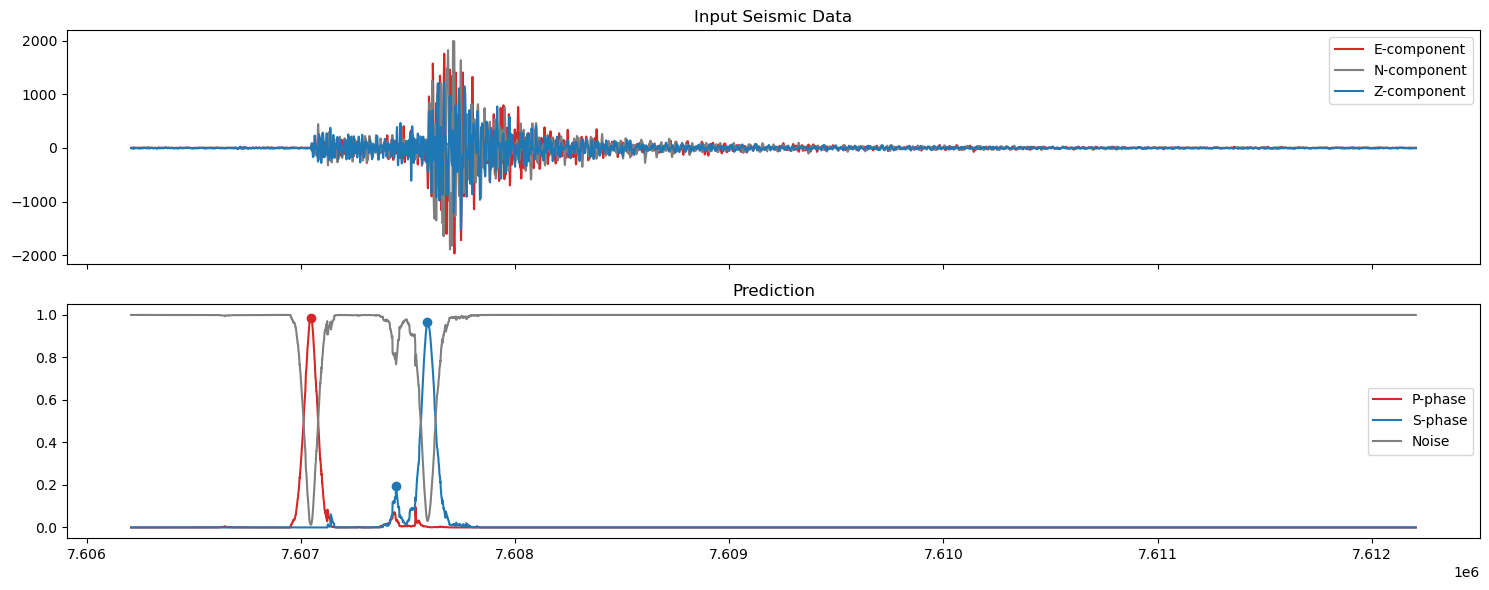

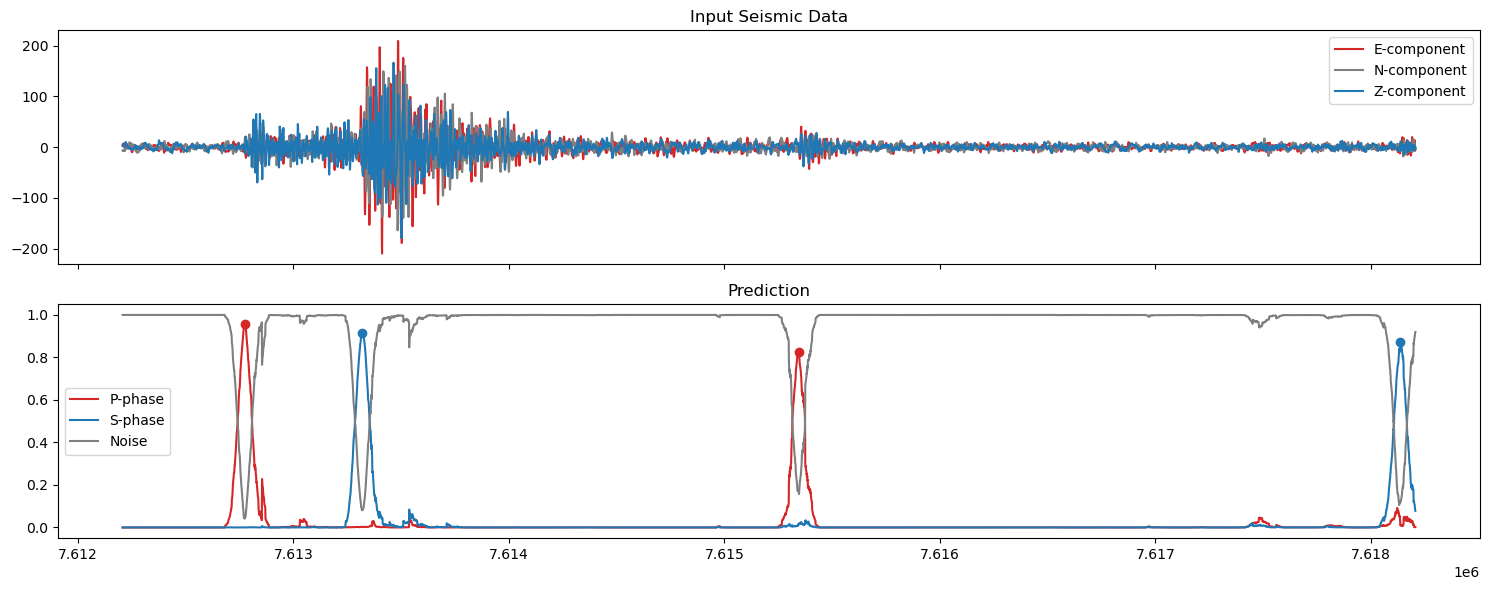

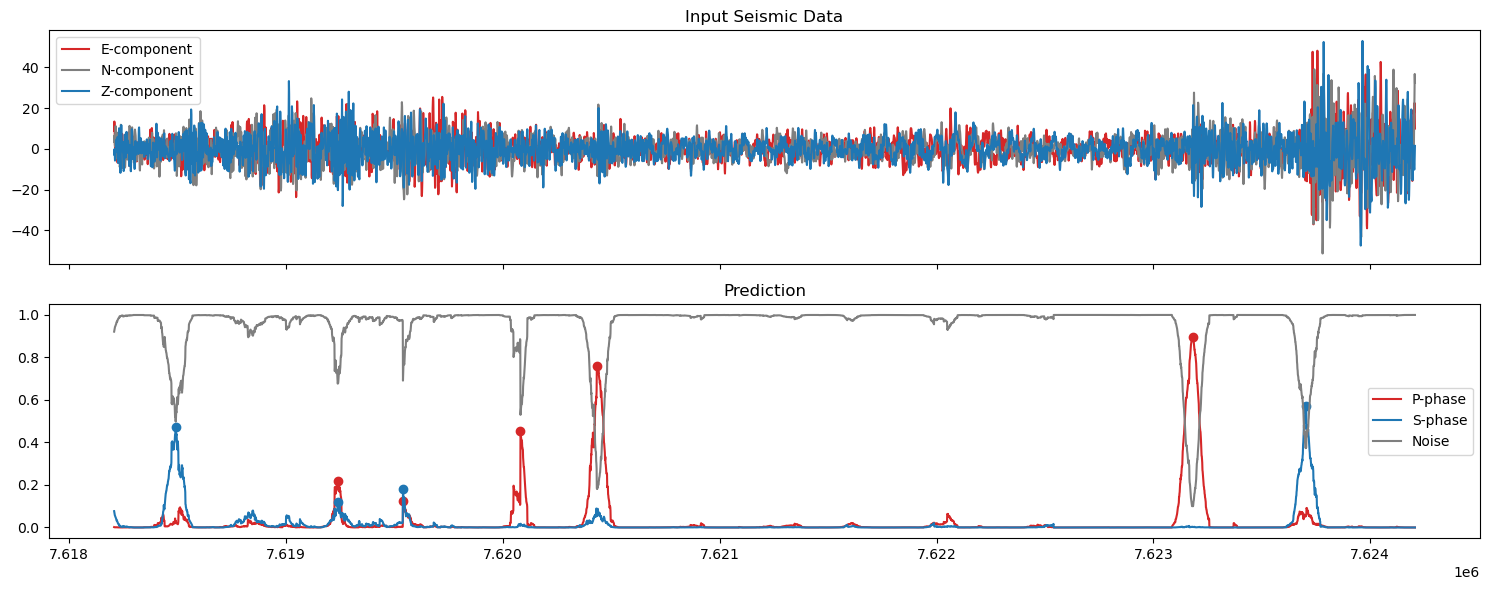

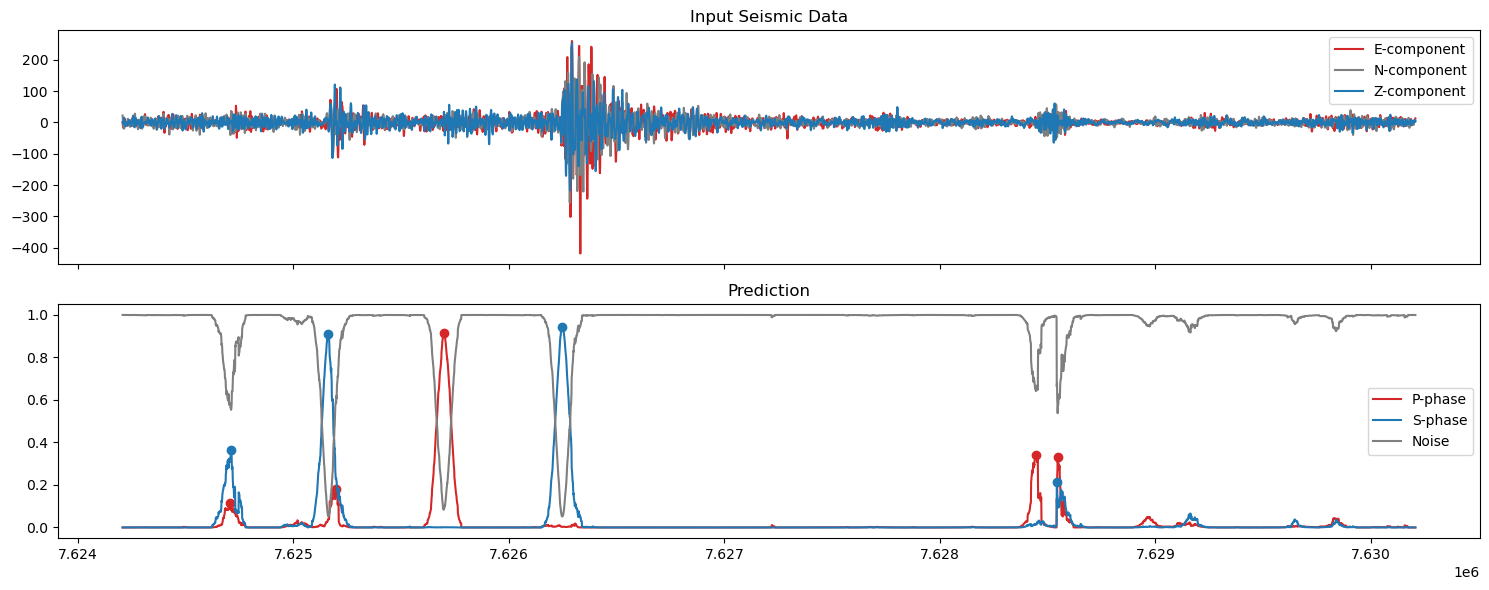

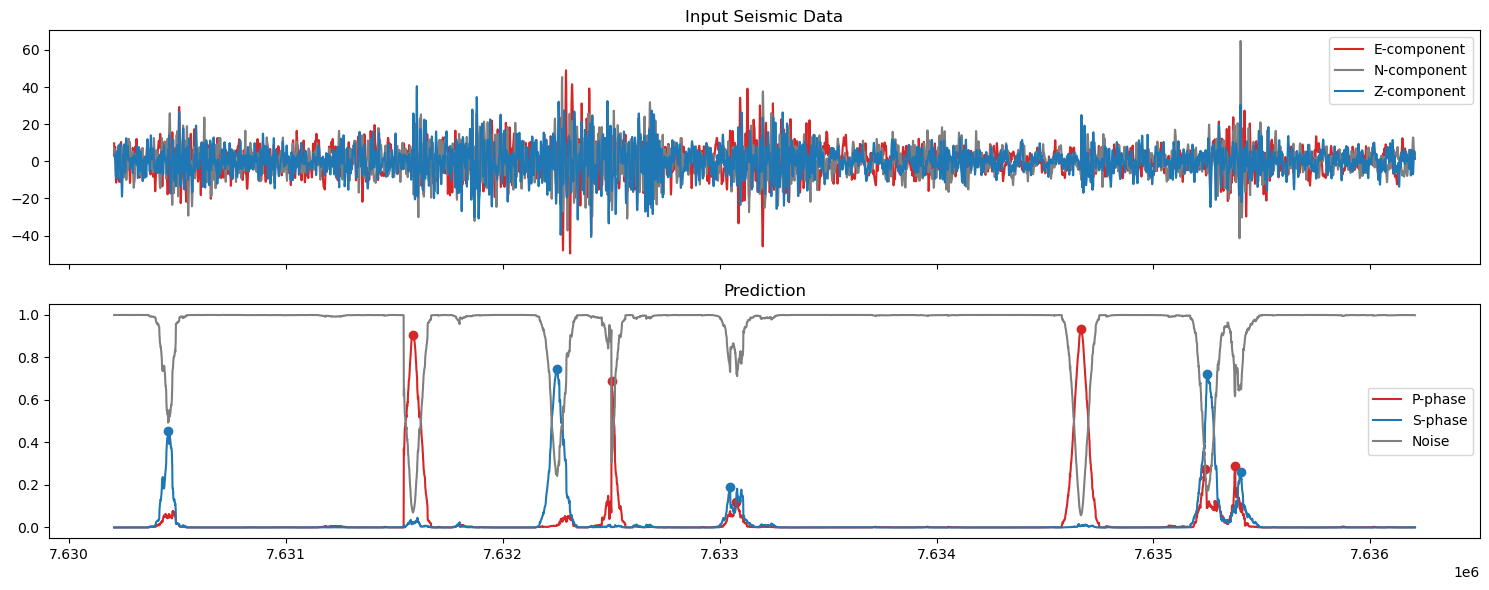

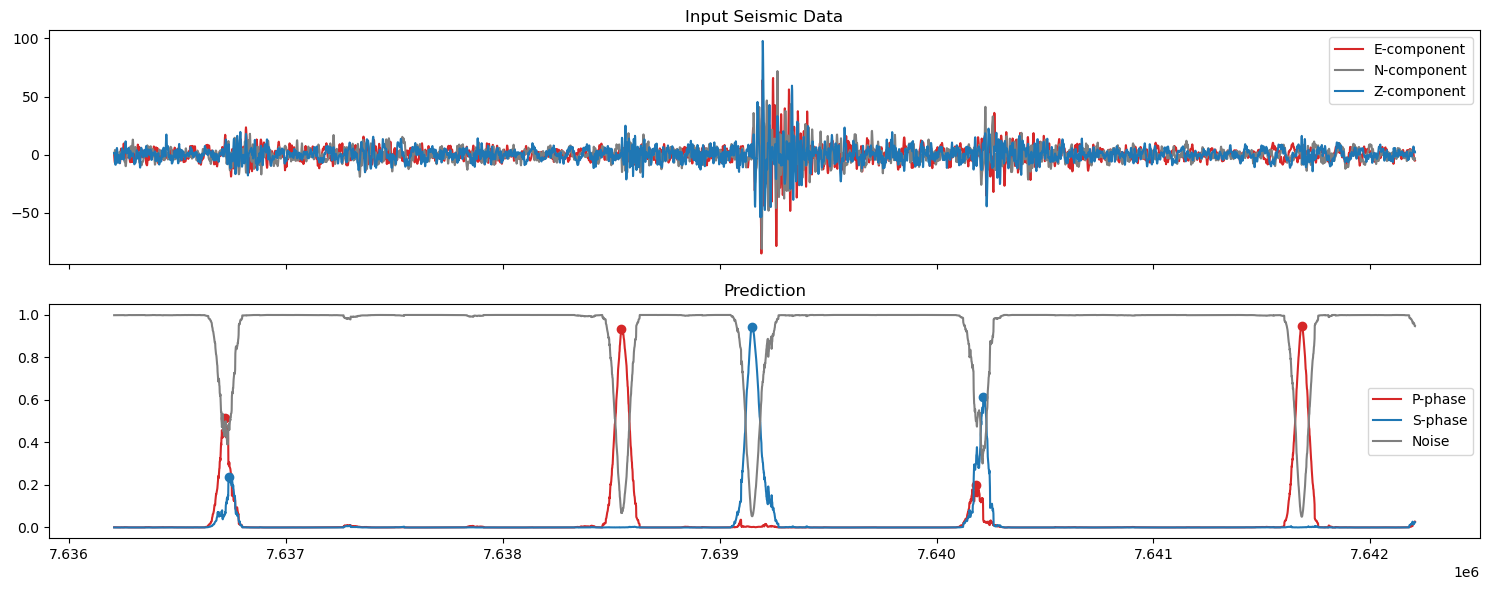

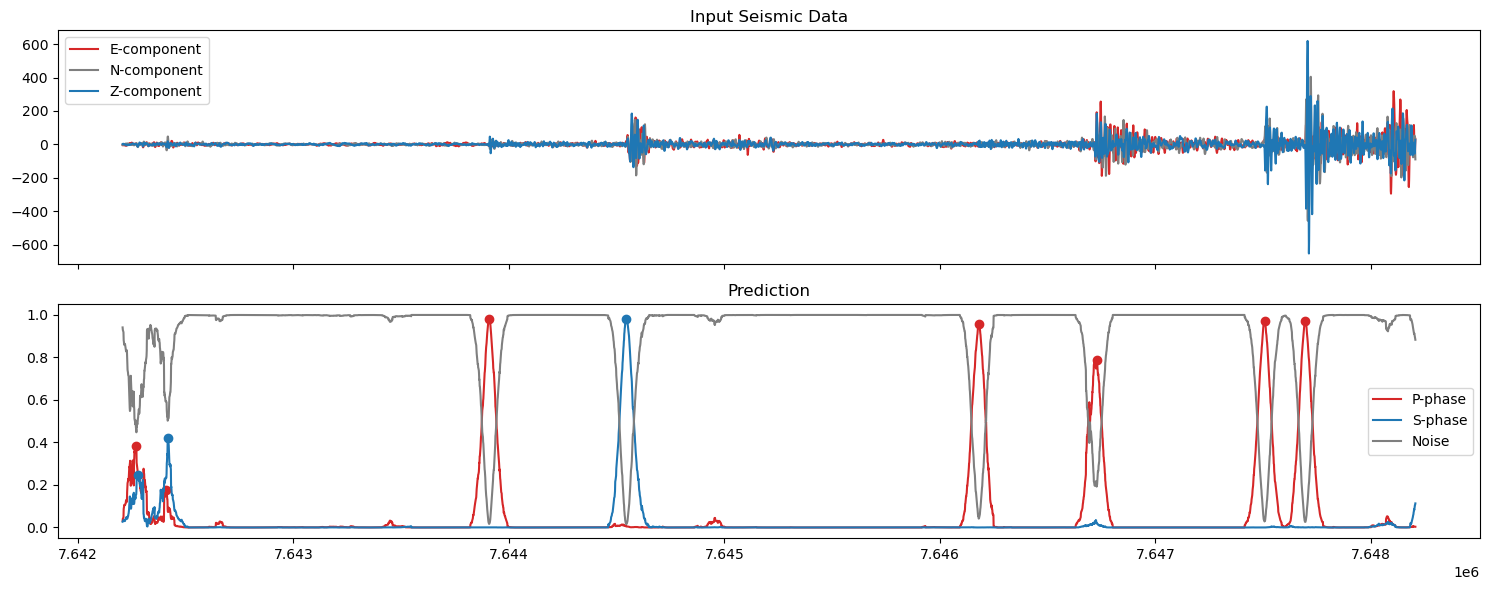

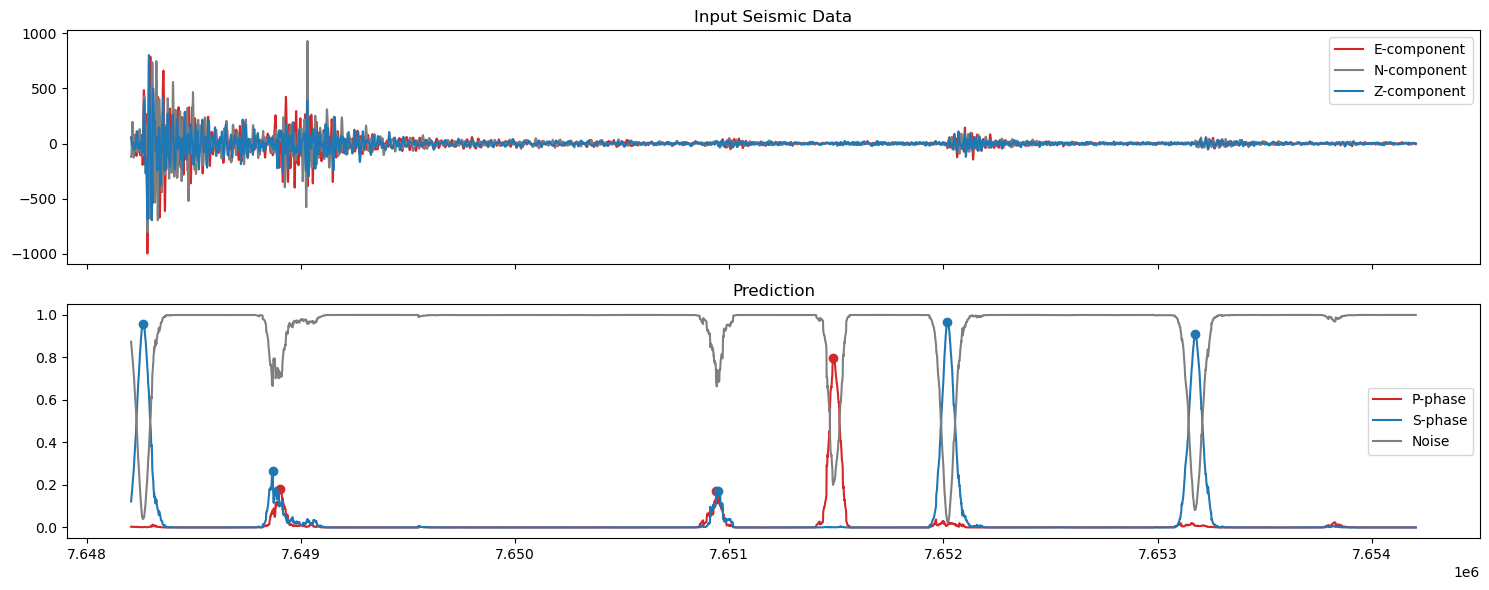

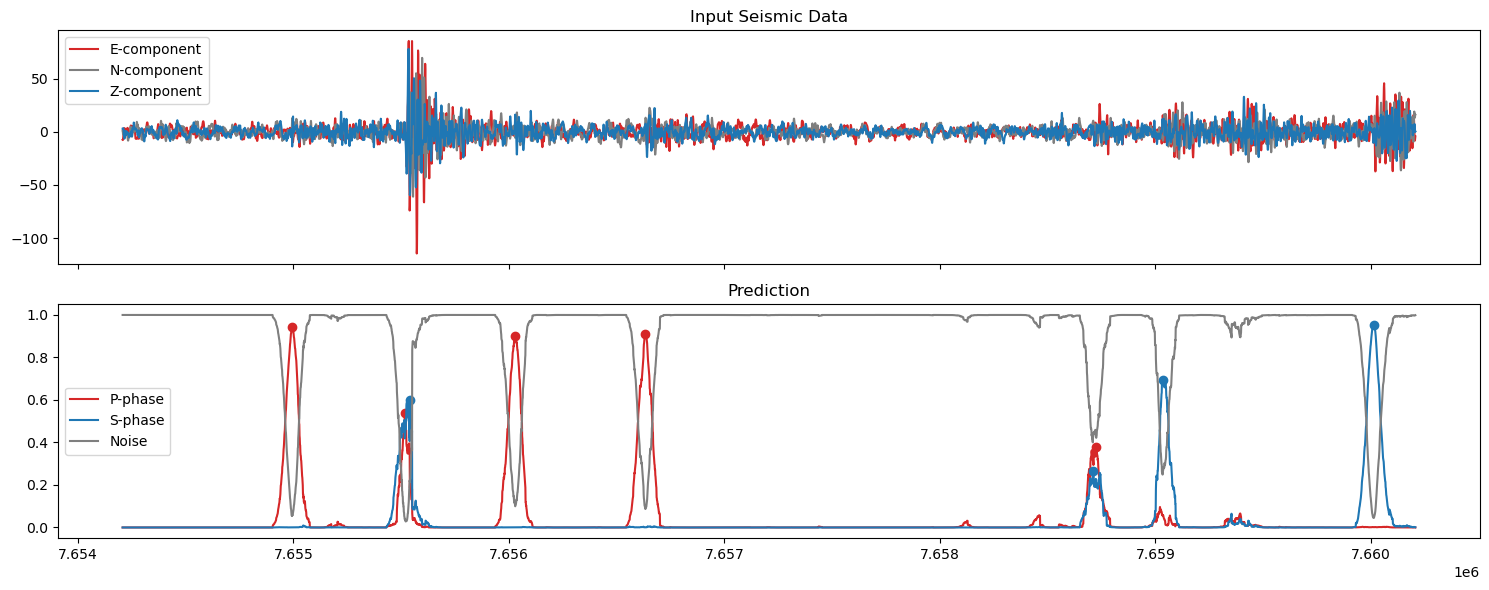

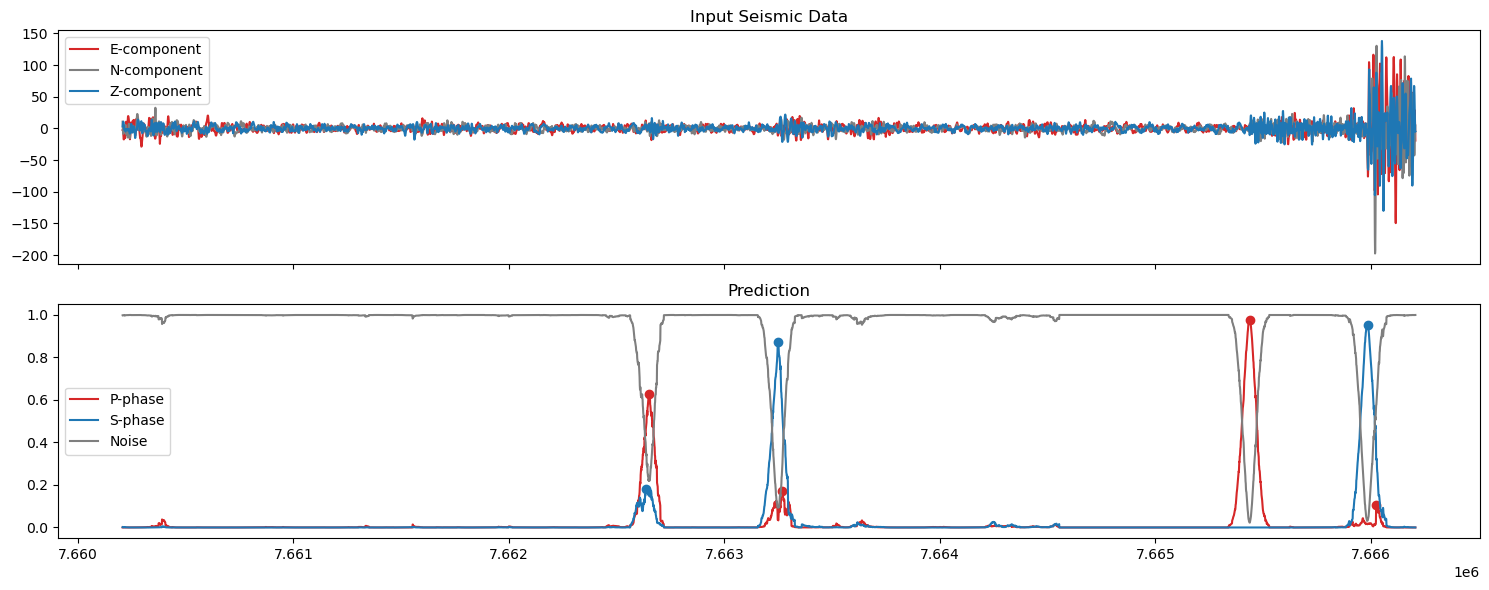

In [41]:
import pandas as pd

# Apply bandpass filter to each trace in-place
st.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=4, zerophase=True)
plot_data = np.stack([tr.data for tr in st], axis=0)  # shape: (channels, time)

# load pick file
picks=pd.read_csv(output_file)

# Find max amplitude (for plotting)
maxind=np.where(plot_data[2,:]==np.max(plot_data[2,:]))[0][0]
winlen=6000 # window length in samples

for ii in np.arange(maxind//winlen-1,maxind//winlen+9):
    fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
    # Define start and finish indices for the window
    start=maxind+ii*6000
    finish=start+6000
    # filter picks
    ppicks_filtered = picks[(picks['index'] >= start) & (picks['index'] < finish) & (picks['phase'] =='P')]
    spicks_filtered = picks[(picks['index'] >= start) & (picks['index'] < finish) & (picks['phase'] =='S')]
    # Plot the data
    axs[0].set_title('Input Seismic Data')
    axs[0].plot(np.arange(start,finish),plot_data[0,start:finish], label='E-component',color='tab:red')
    axs[0].plot(np.arange(start,finish),plot_data[1,start:finish], label='N-component',color='tab:grey')
    axs[0].plot(np.arange(start,finish),plot_data[2,start:finish], label='Z-component',color='tab:blue')
    axs[0].legend()
    axs[1].set_title('Prediction')
    axs[1].plot(np.arange(start,finish),pred_unwrapped[0,start:finish], label='P-phase', color='tab:red')
    axs[1].plot(ppicks_filtered['index'],ppicks_filtered['confidence'],'o',color='tab:red')
    axs[1].plot(np.arange(start,finish),pred_unwrapped[1,start:finish], label='S-phase', color='tab:blue')
    axs[1].plot(spicks_filtered['index'],spicks_filtered['confidence'],'o',color='tab:blue')
    axs[1].plot(np.arange(start,finish),pred_unwrapped[2,start:finish], label='Noise', color='tab:grey')
    axs[1].legend()
    plt.tight_layout()
    plt.show()